In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy as sp
import scipy.optimize as op
from scipy.interpolate import UnivariateSpline
import copy 

In [3]:
data = pd.read_excel("241.ods", engine='odf', nrows=24, usecols="A:F")
data.head(24)

,Tup,pup,dhup,Tdown,pdown,dhdown
0,22.0,6460.96,47.6,15,4883.36,36.0
1,23.0,6569.76,48.4,16,4992.16,36.8
2,24.0,7032.16,51.8,17,5372.96,39.6
3,25.0,7521.76,55.4,18,5563.36,41.0
4,26.0,7848.16,57.8,19,5835.36,43.0
5,27.0,8310.56,61.2,20,6161.76,45.4
6,28.0,8800.16,64.8,21,6569.76,48.4
7,29.0,9316.96,68.6,22,6732.96,49.6
8,30.0,9833.76,72.4,23,7140.96,52.6
9,31.0,10377.76,76.4,24,7467.36,55.0


In [4]:
def lin_plot(x, y, color, marker = '.'):
    coeffs = np.polyfit(x, y, 1)
    equ = lambda x: coeffs[0] * x + coeffs[1]
    
    # plt.scatter(x, y, marker=marker, color = color)
    x_space = np.linspace(min(x)/1.01, max(x)*1.01, 100)
    plt.plot(x_space, equ(x_space), color = color)

In [5]:
T_up   = np.array(273 + data['Tup'].dropna())
T_dw   = np.array(273 + data['Tdown'].dropna())
p_up   = np.array(data['pup'].dropna())
p_dw   = np.array(data['pdown'].dropna())

inv_T_up   = 1/T_up
inv_T_dw   = 1/T_dw
ln_p_up    = np.log(p_up)
ln_p_dw    = np.log(p_dw)

dpdT_up = (np.delete(np.roll(p_up, -1), p_up.size - 1) - np.delete(np.roll(p_up, 0), p_up.size - 1)) \
        / (np.delete(np.roll(T_up, -1), T_up.size - 1) - np.delete(np.roll(T_up, 0), T_up.size - 1)) 
dpdT_dw = (np.delete(np.roll(p_dw, -1), p_dw.size - 1) - np.delete(np.roll(p_dw, 0), p_dw.size - 1)) \
        / (np.delete(np.roll(T_dw, -1), T_dw.size - 1) - np.delete(np.roll(T_dw, 0), T_dw.size - 1)) 
P_T2_up = p_up[:p_up.size - 1]/((T_up[:T_up.size - 1])**2)
P_T2_dw = p_dw[:p_dw.size - 1]/((T_dw[:T_dw.size - 1])**2)

print(p_up.size)
print(dpdT_up.size)

18
17


## График P(T)

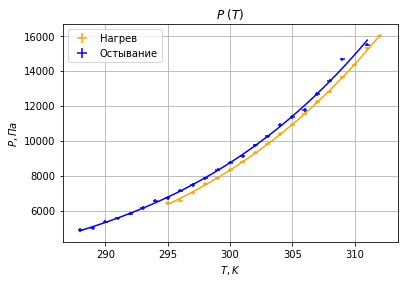

In [6]:
x_spc = np.linspace(T_dw.min(), T_dw.max(), 100)
spline = UnivariateSpline(T_dw, p_dw, s=1000000)
plt.plot(x_spc, spline(x_spc), c='blue')

x_spc = np.linspace(T_up.min(), T_up.max(), 100)
spline = UnivariateSpline(T_up, p_up, s=1000000)
plt.plot(x_spc, spline(x_spc), c='orange')

plt.errorbar(T_up, p_up, yerr=100, xerr=0.2, fmt='none', c='orange', label='Нагрев', )
plt.errorbar(T_dw, p_dw, yerr=100, xerr=0.2, fmt='none', c='blue',   label='Остывание')

plt.title("$P \; (T)$")
plt.ylabel(r"$ P, Па$")
plt.xlabel(r"$ T, K$")
plt.grid(True)
plt.legend()

plt.savefig("pic1.pdf")

## ln P (1/T)

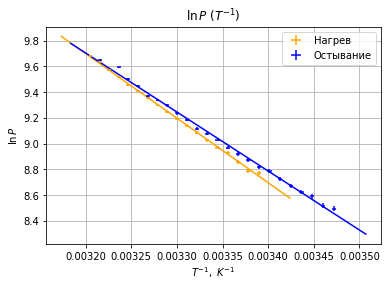

In [7]:
lin_plot(inv_T_up, ln_p_up, color = 'orange')
lin_plot(inv_T_dw, ln_p_dw, color = 'blue')

plt.errorbar(inv_T_up, ln_p_up, xerr=0.2/(T_up**2), yerr=100/(p_up), c='orange', label='Нагрев', fmt='none')
plt.errorbar(inv_T_dw, ln_p_dw, xerr=0.2/(T_dw**2), yerr=100/(p_dw), c='blue',   label='Остывание', fmt='none')

plt.title("$\ln P \; (T^{-1})$")
plt.ylabel(r"$\ln P$")
plt.xlabel(r"$T^{-1}, \; K^{-1}$")
plt.grid(True)
plt.legend()
plt.savefig("pic2.pdf")

In [8]:
def least_sq(x, y):
    sx = (x**2).mean() - (x.mean())**2
    sy = (y**2).mean() - (y.mean())**2
    rxy = (y*x).mean() - (y.mean() * x.mean())
    a = rxy / sx
    da = (1/(len(x) - 2) * (sy/sx - a**2))**(0.5)
    b = y.mean() - a * x.mean()
    db = da*(sx + (x.mean())**2)**(1/2)
    dat = pd.DataFrame({
        '$\overline{x}$' : [x.mean()],
        '$\sigma_x^2$'   : [sx],
        '$\overline{y}$' : [y.mean()],
        '$\sigma_y^2$'   : [sy],
        '$r_{xy}$'       : [rxy],
        '$a$'            : [a],
        '$\Delta a$'     : [da],
        '$b$'            : [b],
        '$\Delta b$'     : [db],
    })
    return dat, [x.mean(), sx, y.mean(), sy, rxy, a, da, b, db]

In [9]:

pt2_up = np.append(P_T2_up, 0)
dpdt_up = np.append(dpdT_up, 0)
pt2_dw = np.append(P_T2_dw, 0)
dpdt_dw = np.append(dpdT_dw, 0)

out = pd.DataFrame({'T' : T_up, 'p' : p_up, '1/T' : inv_T_up, 'lnp' : ln_p_up, 'P_T2' : pt2_up, 'dpdT' : dpdt_up})

names = {
    'T' : r"$T, \text{K}$",
    'p' : r"$p, \text{Па}$",
    '1/T' : r"$\frac{1}{T}, \text{K}$",
    'lnp' : r"$\ln p$",
    'P_T2' : r"$\frac{p}{T^2}$",
    'dpdT' : r"$\frac{dp}{dt}$"
}

out_fmt = {
    names['T'] : "{:.1f}",
    names['p'] : "{:.1f}",
    names['1/T'] : "{:.5f}",
    names['lnp'] : "{:.3f}",
    names['P_T2'] : "{:.4f}",
    names['dpdT'] : "{:.2f}",
}

latex = out.rename(
            columns=(names)
        ).style.hide(level=0, axis=0).format(out_fmt).to_latex(
            buf = 'heating.tex',
            label = 'tab:linear',
            caption = r'Нагрев',
            column_format="c" * 6 ,
            # position_float = 'centering',
            hrules=True,
            multicol_align = 'c',
            environment = r'subtable',
        )

a_file = open("heating.tex", "r")
list_of_lines = a_file.readlines()
list_of_lines[0] = r'\begin{subtable}{0.40\textwidth}'

a_file = open("heating.tex", "w")
a_file.writelines(list_of_lines)
a_file.close()

out = pd.DataFrame({'T' : T_dw, 'p' : p_dw, '1/T' : inv_T_dw, 'lnp' : ln_p_dw, 'P_T2' : pt2_dw, 'dpdT' : dpdt_dw})

latex = out.rename(
            columns=(names)
        ).style.hide(level=0, axis=0).format(out_fmt).to_latex(
            buf = 'freezing.tex',
            label = 'tab:linear',
            caption = r'Охлаждение',
            column_format="c" * 6 ,
            # position_float = 'centering',
            hrules=True,
            multicol_align = 'c',
            environment = r'subtable'
        )

a_file = open("freezing.tex", "r")
list_of_lines = a_file.readlines()
list_of_lines[0] = r'\begin{subtable}{0.40\textwidth}'

a_file = open("freezing.tex", "w")
a_file.writelines(list_of_lines)
a_file.close()


In [10]:
mnk_fmt = {
        '$\overline{x}$' : "{:.2e}",
        '$\sigma_x^2$'   : "{:.2e}",
        '$\overline{y}$' : "{:.2f}",
        '$\sigma_y^2$'   : "{:.2e}",
        '$r_{xy}$'       : "{:.2e}",
        '$a$'            : "{:.2f}",
        '$\Delta a$'     : "{:.2f}",
        '$b$'            : "{:.2f}",
        '$\Delta b$'     : "{:.2f}",
}

df, dat = least_sq(inv_T_up, ln_p_up)

latex = df.style.hide(level=0, axis=0).format(mnk_fmt).to_latex()
print(latex)
df

\begin{tabular}{rrrrrrrrr}
$\overline{x}$ & $\sigma_x^2$ & $\overline{y}$ & $\sigma_y^2$ & $r_{xy}$ & $a$ & $\Delta a$ & $b$ & $\Delta b$ \\
3.30e-03 & 3.18e-09 & 9.22 & 8.01e-02 & -1.59e-05 & -5017.70 & 38.63 & 25.76 & 0.13 \\
\end{tabular}



,$\overline{x}$,$\sigma_x^2$,$\overline{y}$,$\sigma_y^2$,$r_{xy}$,$a$,$\Delta a$,$b$,$\Delta b$
0,0.003296,3.176452e-09,9.218133,0.08005,-0.000016,-5017.696962,38.6324,25.755741,0.127345


In [11]:
df, dat = least_sq(inv_T_dw, ln_p_dw)

latex = df.style.hide(level=0, axis=0).format(mnk_fmt).to_latex()
print(latex)
df

\begin{tabular}{rrrrrrrrr}
$\overline{x}$ & $\sigma_x^2$ & $\overline{y}$ & $\sigma_y^2$ & $r_{xy}$ & $a$ & $\Delta a$ & $b$ & $\Delta b$ \\
3.35e-03 & 5.63e-09 & 9.04 & 1.19e-01 & -2.58e-05 & -4584.45 & 56.75 & 24.37 & 0.19 \\
\end{tabular}



,$\overline{x}$,$\sigma_x^2$,$\overline{y}$,$\sigma_y^2$,$r_{xy}$,$a$,$\Delta a$,$b$,$\Delta b$
0,0.003346,5.630038e-09,9.035668,0.118709,-0.000026,-4584.453586,56.751002,24.373774,0.189918


In [12]:
8.31 / 0.046 * 5018

906512.6086956522

In [13]:
39 / 5017 * 906512

7046.834363165239

In [14]:
8.31 / 0.046 * 4584

828109.5652173914

In [15]:
57 / 4584 * 828109

10297.166884816754


## dp/dT (P/T^2)

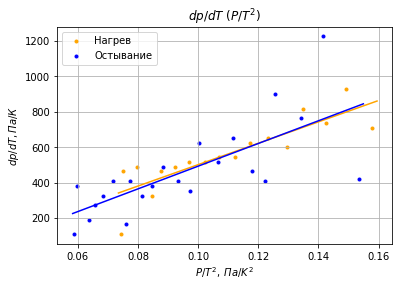

In [16]:
lin_plot(P_T2_up, dpdT_up, color = 'orange')
lin_plot(P_T2_dw, dpdT_dw, color = 'blue')

plt.scatter(P_T2_up, dpdT_up, c='orange', label='Нагрев',    marker='.')
plt.scatter(P_T2_dw, dpdT_dw, c='blue',   label='Остывание', marker='.')

plt.title("$dp/dT\; (P/T^2)$")
plt.ylabel(r"$dp/dT, Па/К$")
plt.xlabel(r"$P/T^{2}, \; Па/K^{2}$")
plt.grid(True)
plt.legend()
plt.savefig("pic3.pdf")

In [17]:
mnk_fmt = {
        '$\overline{x}$' : "{:.2e}",
        '$\sigma_x^2$'   : "{:.2e}",
        '$\overline{y}$' : "{:.2f}",
        '$\sigma_y^2$'   : "{:.2e}",
        '$r_{xy}$'       : "{:.2e}",
        '$a$'            : "{:.2f}",
        '$\Delta a$'     : "{:.2f}",
        '$b$'            : "{:.2f}",
        '$\Delta b$'     : "{:.2f}",
}

df, dat = least_sq(P_T2_up, dpdT_up)

latex = df.style.hide(level=0, axis=0).format(mnk_fmt).to_latex()
print(latex)
df

\begin{tabular}{rrrrrrrrr}
$\overline{x}$ & $\sigma_x^2$ & $\overline{y}$ & $\sigma_y^2$ & $r_{xy}$ & $a$ & $\Delta a$ & $b$ & $\Delta b$ \\
1.10e-01 & 6.61e-04 & 560.00 & 3.27e+04 & 3.99e+00 & 6033.97 & 934.11 & -102.80 & 105.38 \\
\end{tabular}



,$\overline{x}$,$\sigma_x^2$,$\overline{y}$,$\sigma_y^2$,$r_{xy}$,$a$,$\Delta a$,$b$,$\Delta b$
0,0.109845,0.000661,560.0,32732.16,3.990219,6033.96675,934.111495,-102.803629,105.382143


In [18]:
df, dat = least_sq(P_T2_dw, dpdT_dw)

latex = df.style.hide(level=0, axis=0).format(mnk_fmt).to_latex()
print(latex)
df

\begin{tabular}{rrrrrrrrr}
$\overline{x}$ & $\sigma_x^2$ & $\overline{y}$ & $\sigma_y^2$ & $r_{xy}$ & $a$ & $\Delta a$ & $b$ & $\Delta b$ \\
9.55e-02 & 7.45e-04 & 463.02 & 6.03e+04 & 4.77e+00 & 6402.78 & 1413.03 & -148.24 & 140.30 \\
\end{tabular}



,$\overline{x}$,$\sigma_x^2$,$\overline{y}$,$\sigma_y^2$,$r_{xy}$,$a$,$\Delta a$,$b$,$\Delta b$
0,0.095468,0.000745,463.018182,60271.356033,4.768463,6402.777769,1413.025966,-148.24418,140.302499


In [19]:
8.31 * 6034 / 0.046

1090055.2173913044

In [20]:
934 / 6034 * 1090055

168729.09678488562

In [21]:
8.31 * 6403 / 0.046

1156715.8695652175

In [23]:
1413 / 6403 * 1156715

255261.32984538496